In [31]:
# Importing packages and Setting configuration
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, r2_score
from scipy.stats import spearmanr
from xgboost import XGBClassifier

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')
pd.set_option('display.precision',3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction

The goal of the project is improving member-type customer experience and sales based on the supermarket sales dataset.

In [32]:
# Accessing file
work_dir = '/content/drive/MyDrive/Colab Notebooks/Dat_Sci Deep Dive'
data_dir = os.path.join(work_dir, 'Dataset')
filename = 'supermarket_sales.csv'
df = pd.read_csv(os.path.join(data_dir,filename))

In [33]:
# Creating dataset summary
def data_summary(dataframe):
    summary = pd.DataFrame()
    summary['Feature Names'] = dataframe.columns.values
    summary['Data Types'] = dataframe.dtypes.values
    summary['Rows'] = len(dataframe)
    summary['Duplicate Rows'] = dataframe.duplicated().sum()
    summary['Num Missing Val'] = dataframe.isnull().sum().values
    summary['% Missing Val'] = summary['Num Missing Val'] / summary['Rows']
    summary['Num Unique Val'] = dataframe.nunique().values
    summary['% Unique Val'] = summary['Num Unique Val'] / summary['Rows']
    return summary
  
summary = data_summary(df)
summary

,Feature Names,Data Types,Rows,Duplicate Rows,Num Missing Val,% Missing Val,Num Unique Val,% Unique Val
0,Invoice ID,object,1000,0,0,0.0,1000,1.000
1,Branch,object,1000,0,0,0.0,3,0.003
2,City,object,1000,0,0,0.0,3,0.003
3,Customer type,object,1000,0,0,0.0,2,0.002
4,Gender,object,1000,0,0,0.0,2,0.002
5,Product line,object,1000,0,0,0.0,6,0.006
6,Unit price,float64,1000,0,0,0.0,943,0.943
7,Quantity,int64,1000,0,0,0.0,10,0.010
8,Tax 5%,float64,1000,0,0,0.0,990,0.990
9,Total,float64,1000,0,0,0.0,990,0.990


# Formatting Dataset

In [34]:
# Formatting dataframe
print('[INFO] Formatting dataframe...')
df['City Branch'] = df['City'] + ' ' + df['Branch']
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Month'] = pd.to_datetime(df['Datetime']).dt.strftime('%B')
df['Hour'] = pd.to_datetime(df['Datetime']).dt.hour
df = df.drop(['City', 'Branch', 'Date', 'Time', 'gross margin percentage'], axis=1)
new_sum = data_summary(df)
new_sum.to_csv('Summary.csv')
print(f'[INFO] Data Summary: \n{new_sum}')
df_stats = df.describe()
df_stats.to_csv('Stats.csv')
print(f'[INFO] Data Stats: \n{df_stats}')

[INFO] Formatting dataframe...
[INFO] Data Summary: 
    Feature Names      Data Types  Rows  Duplicate Rows  Num Missing Val  \
0      Invoice ID          object  1000               0                0   
1   Customer type          object  1000               0                0   
2          Gender          object  1000               0                0   
3    Product line          object  1000               0                0   
4      Unit price         float64  1000               0                0   
5        Quantity           int64  1000               0                0   
6          Tax 5%         float64  1000               0                0   
7           Total         float64  1000               0                0   
8         Payment          object  1000               0                0   
9            cogs         float64  1000               0                0   
10   gross income         float64  1000               0                0   
11         Rating         float64  

In [35]:
# Plot function
def box_plot(dataframe, x_values, y_values, rotation=0, hue=None, figsize=(10,6), title=None, savefig=False):
    sns.set(rc={'figure.dpi': 100, 'savefig.dpi': 100, 'figure.figsize': figsize})
    a = sns.boxplot(x=x_values, y=y_values, hue=hue, data=dataframe)
    a.set_xticklabels(a.get_xticklabels(), rotation=rotation)
    if savefig and title is not None:
        a.set_title(title)
        plt.savefig(title + '.png')
    if savefig == False and title is not None:
      plt.title(title)
      plt.show()
    else:
      plt.close()


def bar_plot(dataframe, x_values, y_values, rotation=0, hue=None, title=None, figsize=(10,6), savefig=False):
    sns.set(rc={'figure.dpi': 100, 'savefig.dpi': 100, 'figure.figsize': figsize})
    a = sns.barplot(data=dataframe, x=x_values, y=y_values, hue=hue)
    a.set_xticklabels(a.get_xticklabels(),rotation=rotation)
    if savefig and title is not None:
        a.set_title(title)
        plt.savefig(title + '.png')
    if savefig == False and title is not None:
      plt.title(title)
      plt.show()
    else:
      plt.close()


def sbs_barplot(dataframe, x_values, hue, rename, rotation=0, title=None, figsize=(10,6), savefig=False):
    dataset = dataframe.groupby([hue])[x_values].value_counts(normalize=True).rename(rename).reset_index()
    sns.set(rc={'figure.dpi': 100, 'savefig.dpi': 100, 'figure.figsize': figsize})
    a = sns.barplot(x=x_values, y=rename, hue=hue, data=dataset)
    a.set_xticklabels(a.get_xticklabels(),rotation=rotation)
    if savefig and title is not None:
        a.set_title(title)
        plt.savefig(title + '.png')
    if savefig == False and title is not None:
      plt.title(title)
      plt.show()
    else:
      plt.close()


def stacked_plot(dataframe, feature, kind='barh', title=None, savefig=False):
    hold = dataframe[feature].value_counts(normalize=True)
    dict = {}
    for i in range(len(hold.index)):
        dict[str(hold.index[i])] = hold[i]
    data = pd.DataFrame(data=dict, index=[feature])
    data.plot(kind=kind, stacked=True)
    plt.xlabel('% Transaction')
    if savefig and title is not None:
        plt.title(title)
        plt.savefig(title + '.png')
    if savefig == False and title is not None:
      plt.title(title)
      plt.show()
    else:
      plt.close()

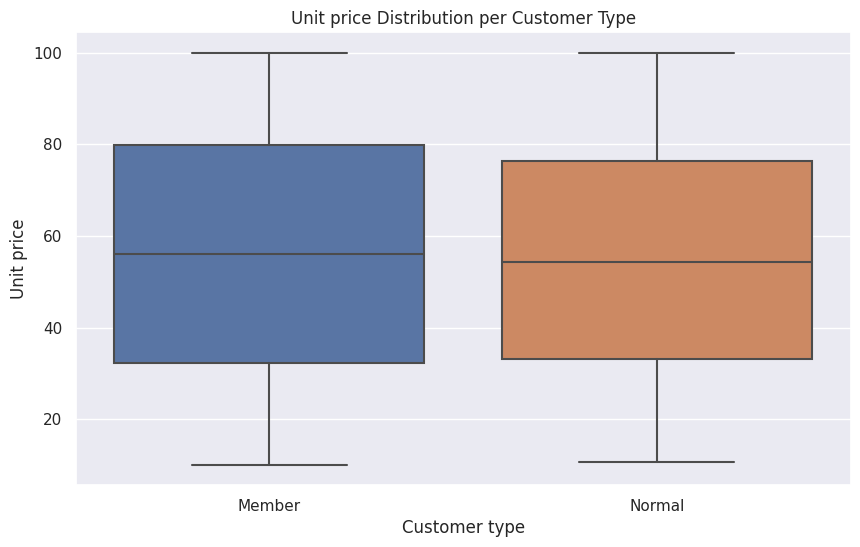

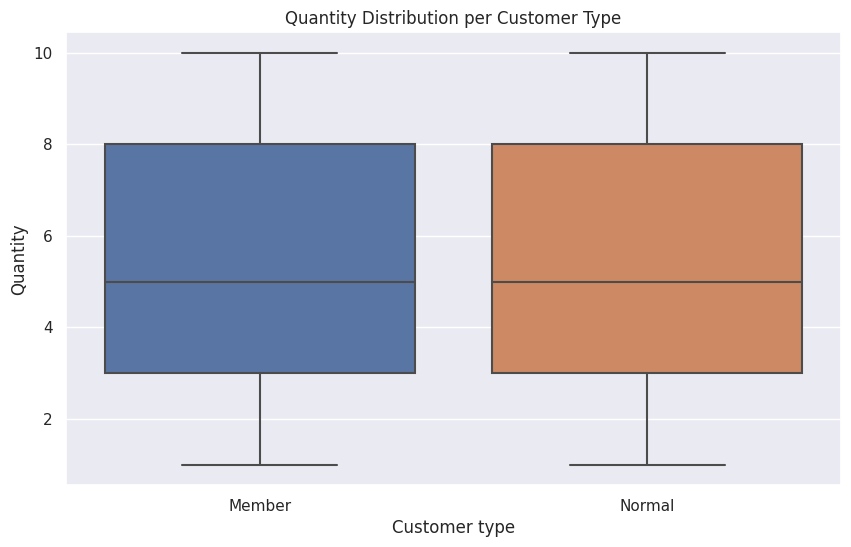

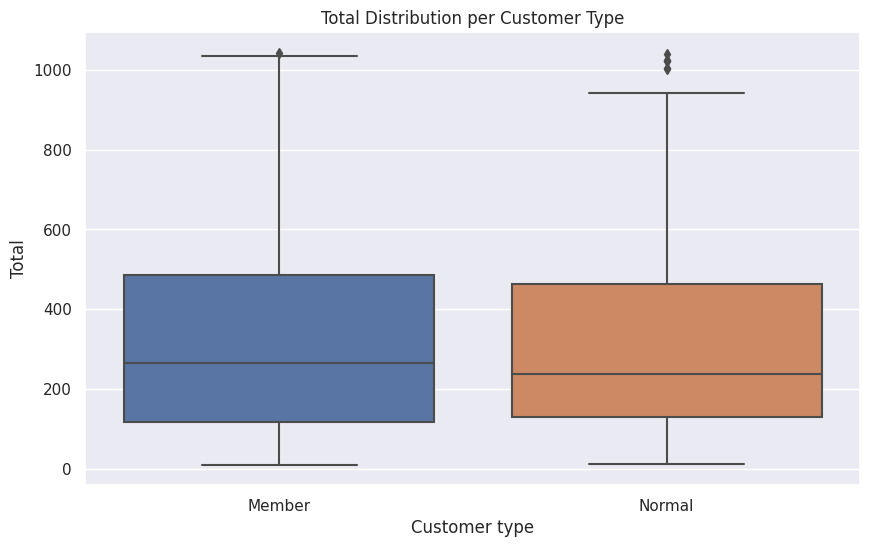

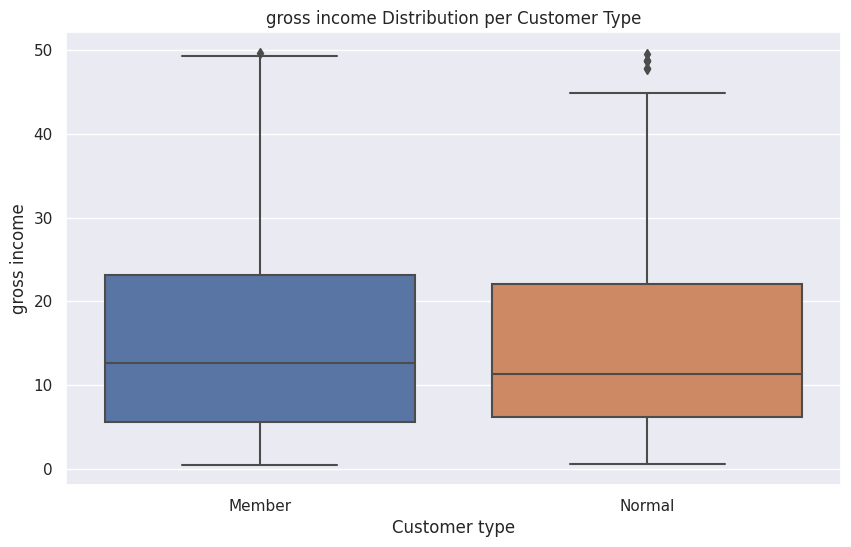

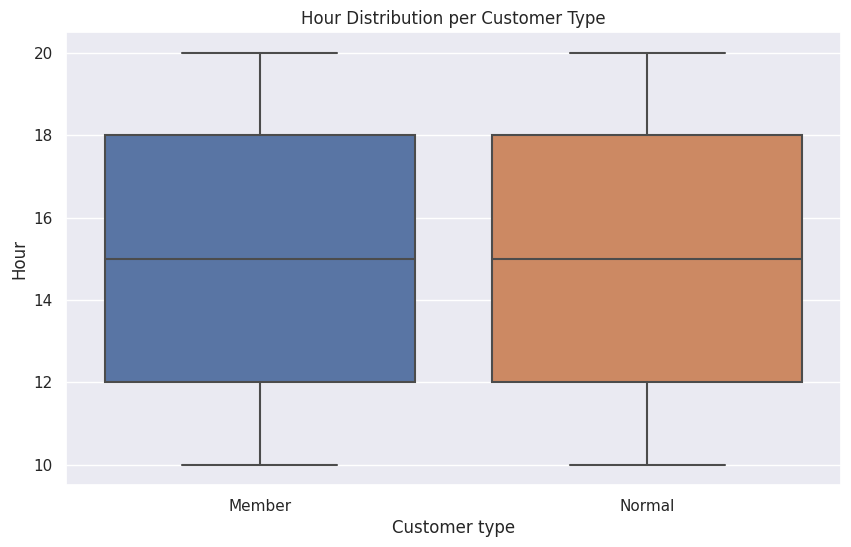

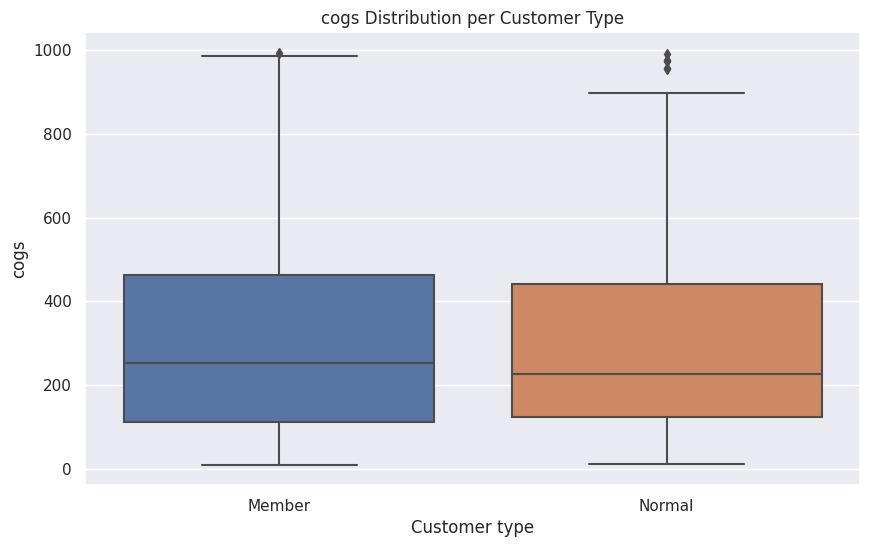

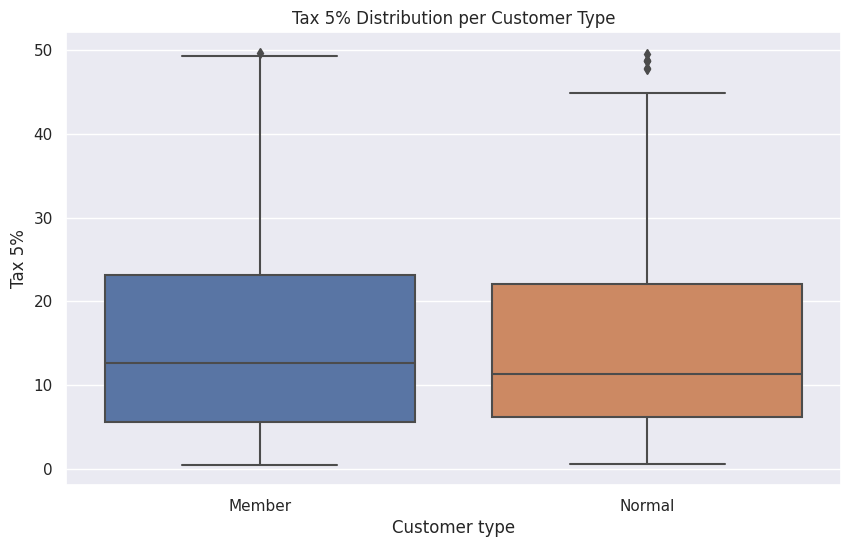

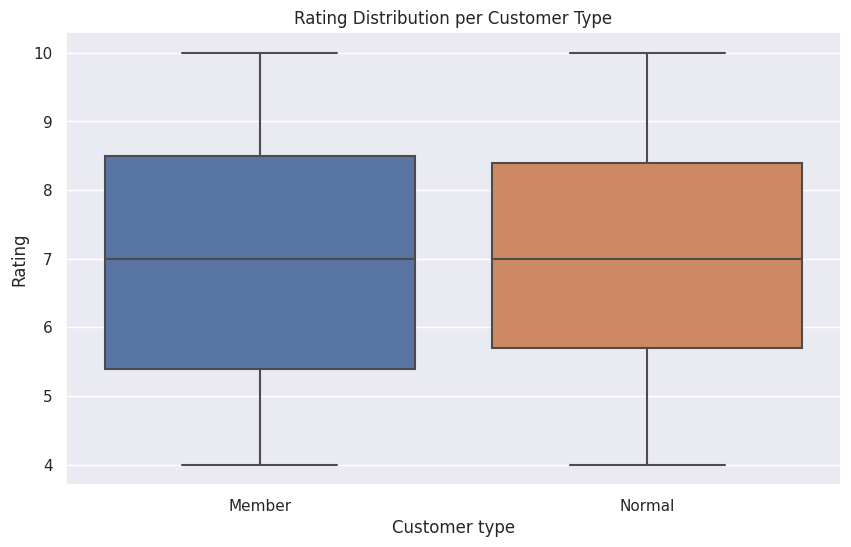

In [36]:
# Data distribution review
df_cat = df[['Invoice ID', 'Customer type', 'City Branch', 'Gender', 'Product line', 'Payment', 'Month']]
df_num = df[['Unit price', 'Quantity', 'Total', 'gross income', 'Hour', 'cogs', 'Tax 5%', 'Rating']]
for feature in df_num.columns.values:
    box_plot(df, 'Customer type', feature, title=(feature + ' Distribution per Customer Type'), savefig=False)

The graph shown above shows the distribution of the numeric feature/variable in the datasets. It shows that there is an outlier in the numeric features.

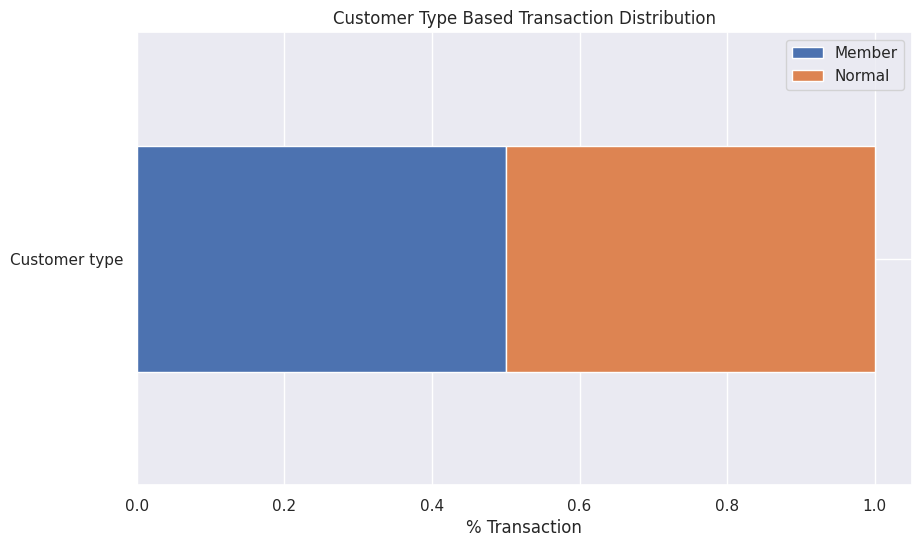

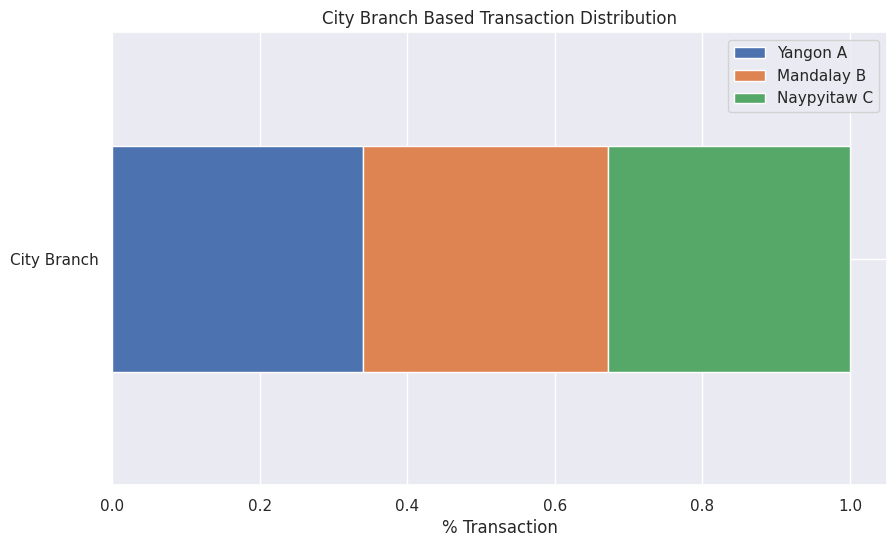

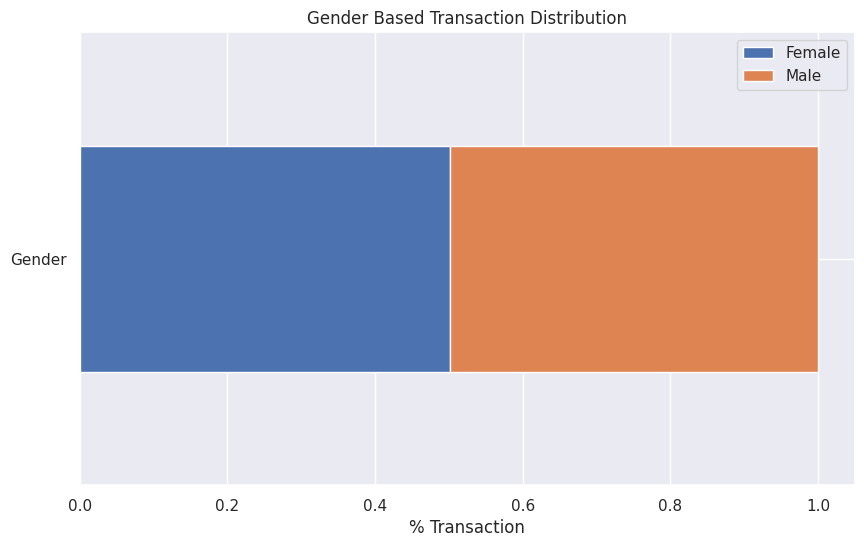

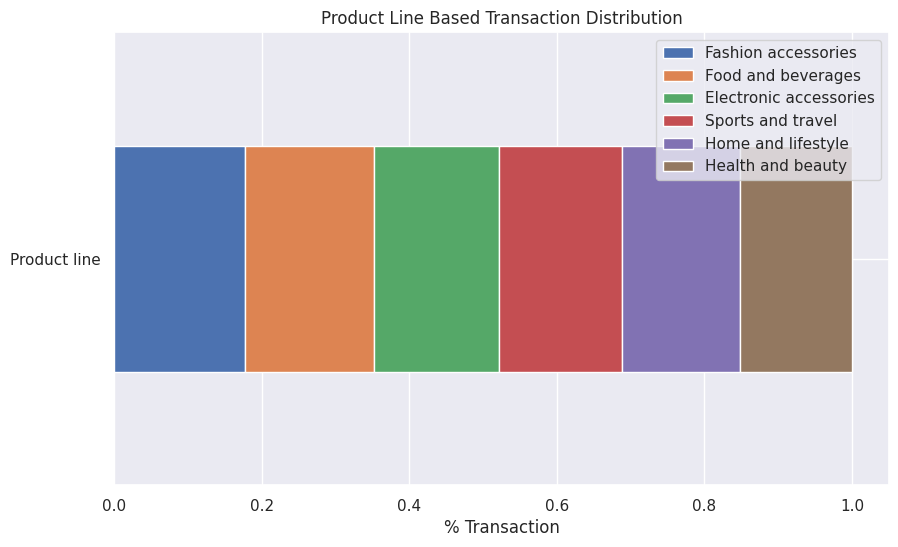

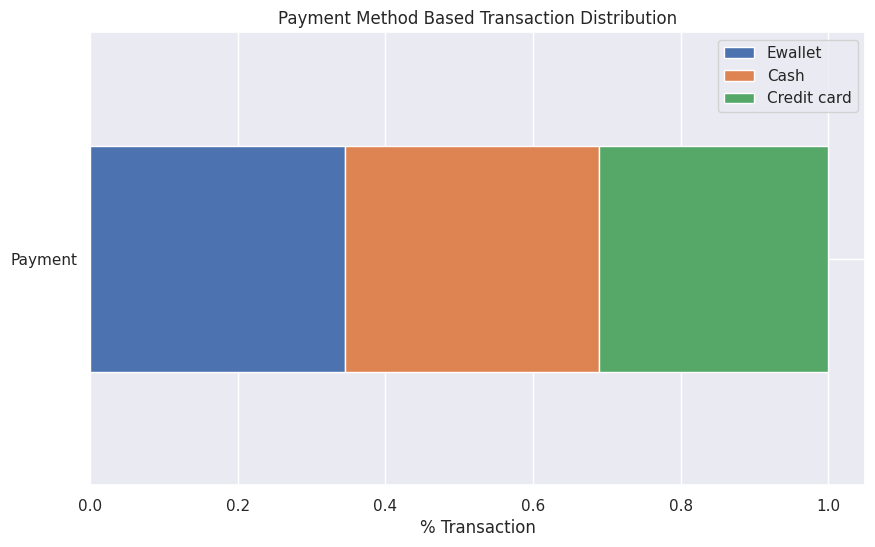

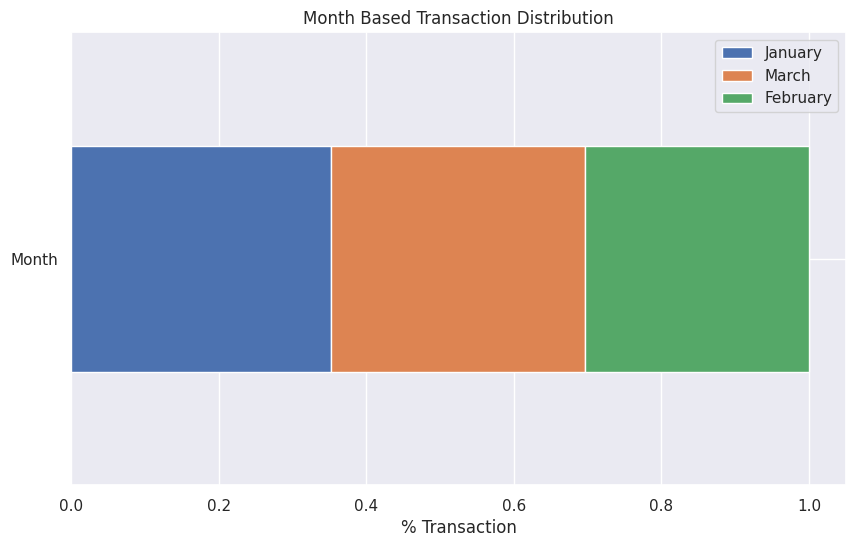

In [37]:
stacked_plot(df, 'Customer type', title='Customer Type Based Transaction Distribution', savefig=False)
stacked_plot(df, 'City Branch', title='City Branch Based Transaction Distribution', savefig=False)
stacked_plot(df, 'Gender', title='Gender Based Transaction Distribution', savefig=False)
stacked_plot(df, 'Product line', title='Product Line Based Transaction Distribution', savefig=False)
stacked_plot(df, 'Payment', title='Payment Method Based Transaction Distribution', savefig=False)
stacked_plot(df, 'Month', title='Month Based Transaction Distribution', savefig=False)

Based on the graph shown above, we can consider the data is good because the distribution of each variable is equally distributed, hence each variable represents their variable equally.

# Data Visualiztion

## Data Exploration

[INFO] Generating insight...


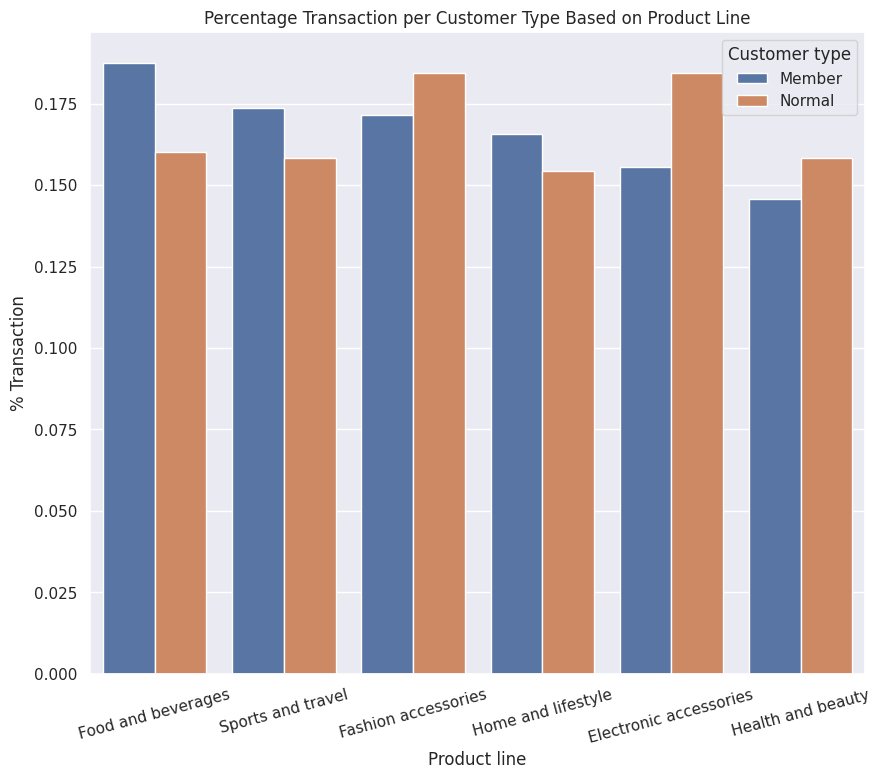

In [38]:
# Generating insight for building hypothesis
## Customer type analysis based on categorical feature
print(f'[INFO] Generating insight...')
sbs_barplot(df, 'Product line', 'Customer type', '% Transaction', rotation=15, title='Percentage Transaction per Customer Type Based on Product Line', figsize=(10,8.5), savefig=False)

The graph shown above tells us that from 100 transaction made by member-type customer, around 18 transactions related to food and beverages product line, around 17 transactions related to sports and travel and fashion accessories product line. Health and beauty product line is the less interesting product line for member-type customer with around 14 transactions from 100 transaction made by member-type customer.

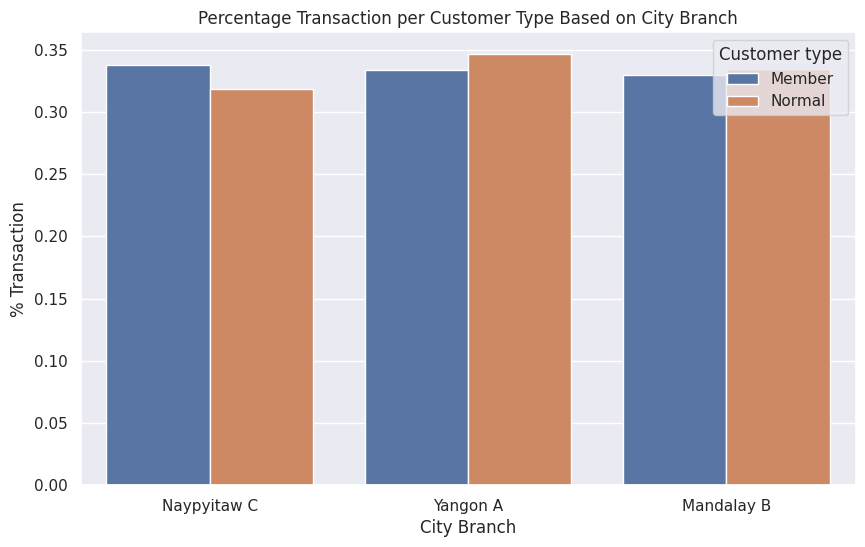

In [39]:
sbs_barplot(df, 'City Branch', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on City Branch', savefig=False)

The graph shown above tells us that from 100 member transaction, 30 to 35 transaction happened in each city equally. 

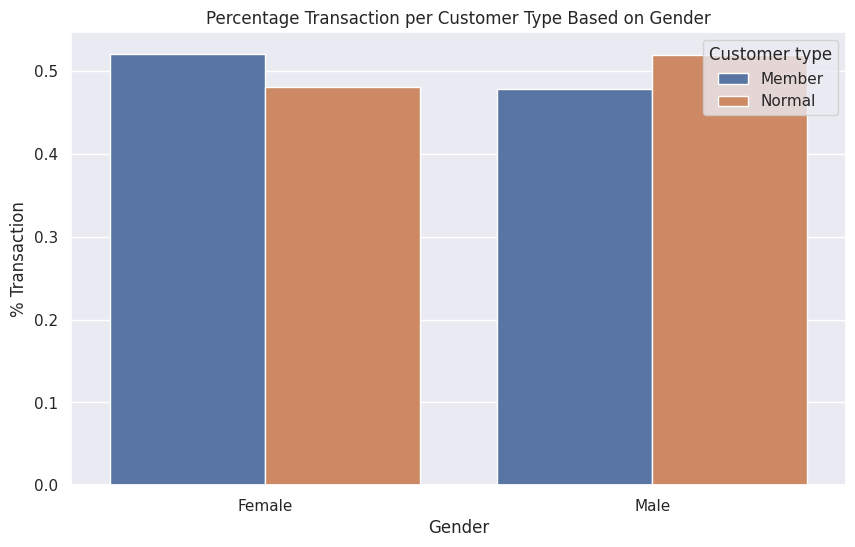

In [40]:
sbs_barplot(df, 'Gender', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on Gender', savefig=False)

The graph shown above tells us that from 100 member transaction, more than 50 transaction of it is female. 

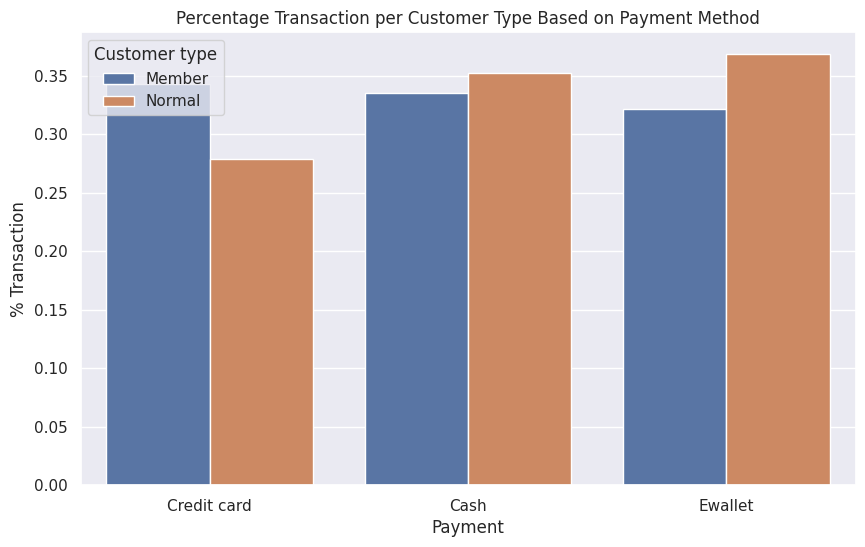

In [41]:
sbs_barplot(df, 'Payment', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on Payment Method', savefig=False)

The graph shown above tells us that our member-type customer slightly prefers to use credit card than cash or e-wallet. Around 34 to 35 transactions from 100 transactions made by member-type customer used credit card as a payment method. 

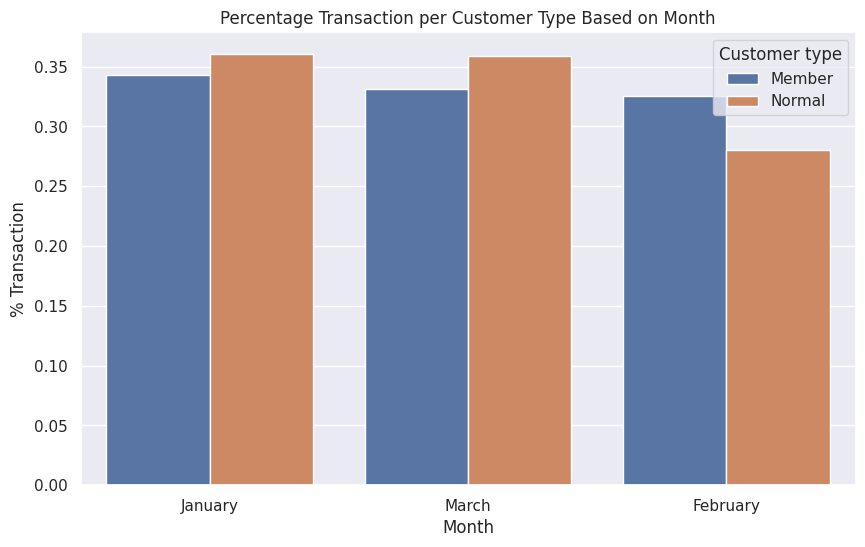

In [42]:
sbs_barplot(df, 'Month', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on Month', savefig=False)

The graph shown above tells us that our member-type customer slightly prefers to shop in January than February or March. 

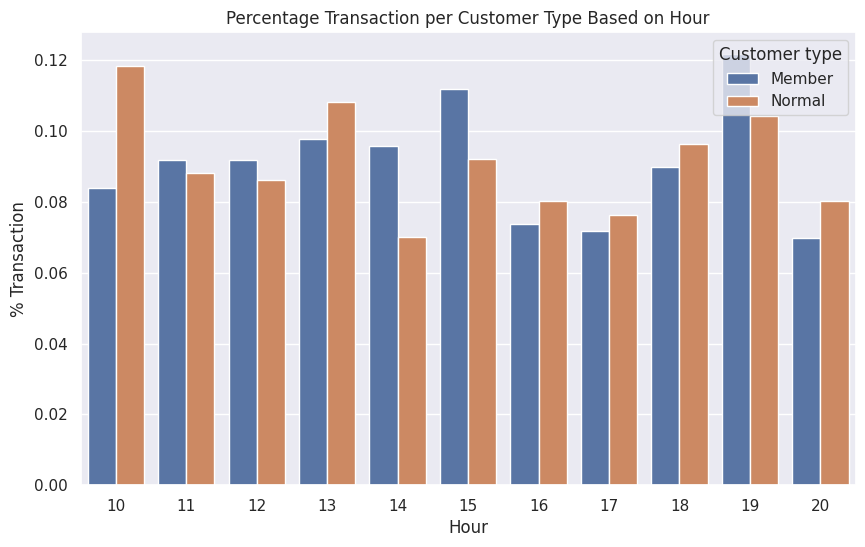

In [43]:
sbs_barplot(df, 'Hour', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on Hour', savefig=False)

Based on the graph shown above, it tells us that from 100 transactions made by a member-type customer, 12 of those transactions are happened in around 19.00 to 20.00 time, another 11 transactions are happened in around 15.00 to 16.00 time. Only around 6 to 7 transactions happened in the 20.00 to 21.00 time. It tells us that a member-type customer prefers to shop in around 19.00 to 20.00 time and 15.00 to 16.00 time.

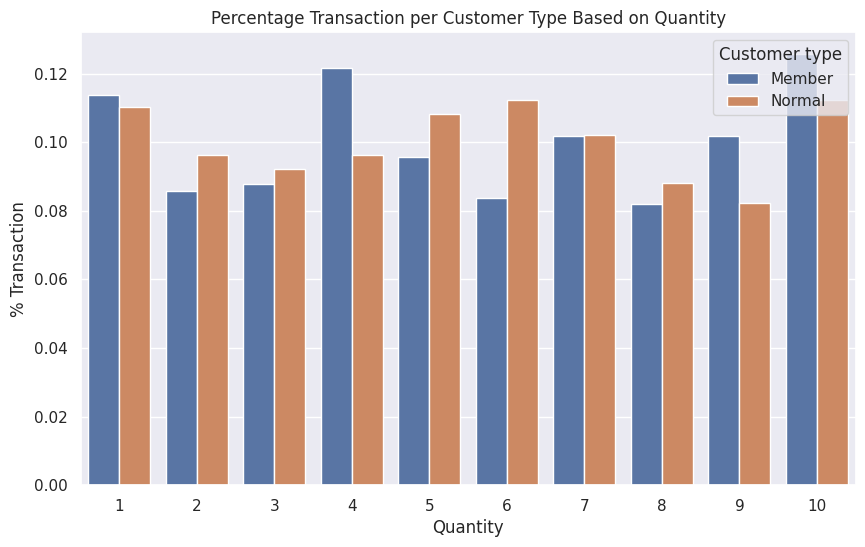

In [44]:
sbs_barplot(df, 'Quantity', 'Customer type', '% Transaction', title='Percentage Transaction per Customer Type Based on Quantity', savefig=False)

Based on the graph shown above, from 100 transactions made by member-type customer, 24 of those transactions are purchasing 4 or 10 items at once. Around 11 transactions are purchasing 1 item at once.

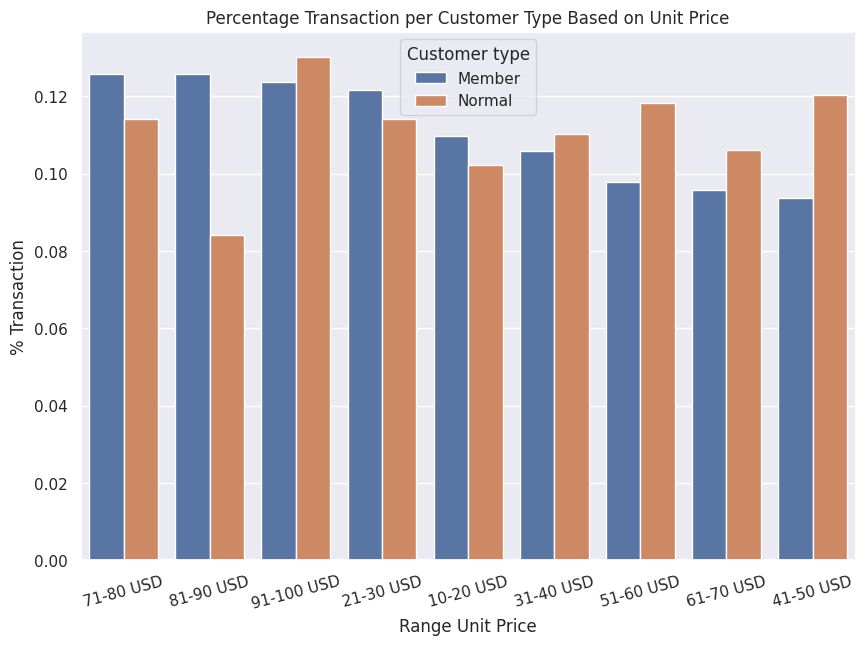

In [45]:
## Binning Unit Price
bins = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
bin_names = ['10-20 USD', '21-30 USD', '31-40 USD', '41-50 USD', '51-60 USD', '61-70 USD', '71-80 USD', '81-90 USD', '91-100 USD']
df['Range Unit Price'] = pd.cut(df['Unit price'], bins=bins, labels=bin_names).astype(str)
sbs_barplot(df, 'Range Unit Price', 'Customer type', '% Transaction',rotation=15, figsize=(10,7), title='Percentage Transaction per Customer Type Based on Unit Price', savefig=False)

The graph shown above tells us that from 100 transaction made by member-type customer, around 36 transactions made a transaction with 71-100 USD unit price, and around 12 transactions made a transaction with 21-30 USD unit price. The graph shows that our member-type customer does not see unit price as a main factor to shop.

In [46]:
# Outlier treatment
print(f'[INFO] Treating outlier...')
up_limit = df_num.quantile(0.95)
low_limit = df_num.quantile(0.05)
more_than = df_num > up_limit
lower_than = df_num < low_limit
df_num_mask = df_num.mask(more_than, up_limit, axis=1)
df_num_mask = df_num_mask.mask(lower_than, low_limit, axis=1)
df_out = pd.concat([df_cat, df_num_mask], axis=1)

[INFO] Treating outlier...


In [47]:
# Encoding categorical features
print(f'[INFO] Encoding categorical features...')
df_out_cat = df_out['Invoice ID']
df_out_num = df_out.drop(['Invoice ID'], axis=1)
df_out_num = pd.get_dummies(df_out_num)
df_out = pd.concat([df_out_num, df_out_cat], axis=1)

[INFO] Encoding categorical features...


## Clustering

In [48]:
# Clustering member-type customer
print(f'[INFO] Clustering...')
## Creating Member-Type Customer Dataframe
df_member = df_out[df_out['Customer type_Member'] == 1]
df_member_id = df_member['Invoice ID']
df_member = df_member.drop(['Customer type_Member', 'Customer type_Normal', 'Invoice ID'], axis=1)
df_notmember = df_out[df_out['Customer type_Normal'] == 1]
df_notmember_id = df_notmember['Invoice ID']
df_notmember = df_notmember.drop(['Customer type_Member', 'Customer type_Normal', 'Invoice ID'], axis=1)

[INFO] Clustering...


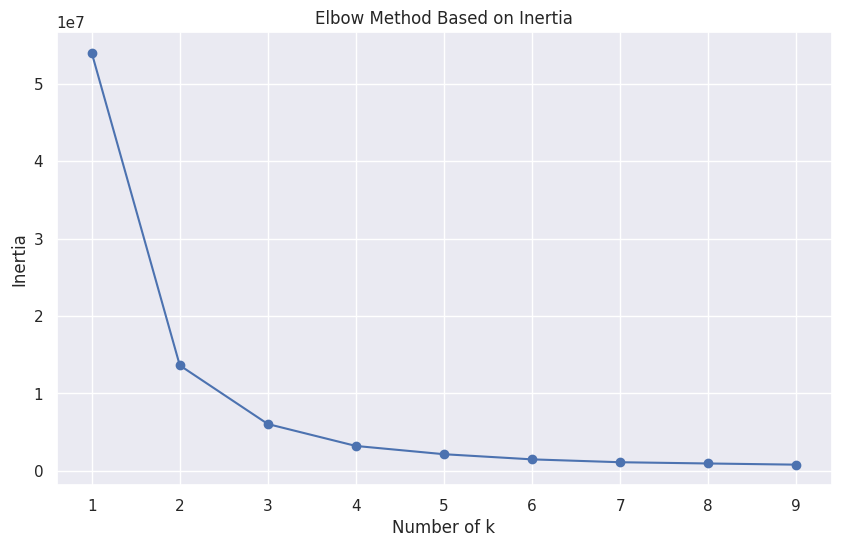

In [49]:
## Standard Scaling
scaler = StandardScaler()
scaler.fit(df_member)

## Clustering
inertias = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, n_init=15, max_iter=400)
    kmean.fit(df_member)
    inertias.append(kmean.inertia_)
plt.figure(figsize=(10,6))
plt.plot(K, inertias, 'bo-')
plt.title('Elbow Method Based on Inertia')
plt.xlabel('Number of k')
plt.ylabel('Inertia')
plt.savefig('Elbow Method Based on Inertia.png')
plt.show()
kmean_model = KMeans(n_clusters=2, n_init=15, max_iter=400)
pred = kmean_model.fit(df_member)
cluster_1 = pred.cluster_centers_[0]
cluster_2 = pred.cluster_centers_[1]
labels = list(pred.labels_)
unique, count = np.unique(labels, return_counts=True)
cluster = pd.DataFrame(list(zip(unique, count)), columns=['Cluster', 'Number of Transaction'])
cluster['Cluster'] = cluster['Cluster'] + 1

Based on the elbow graph shown above, we can conclude that there are two cluster of our member-type customer profile based on our supermarket sales dataset. 

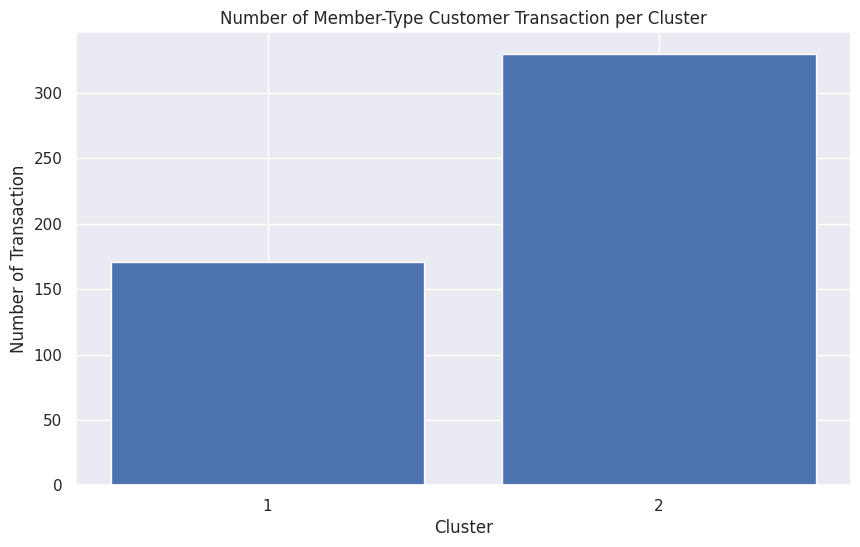

In [50]:
### Visualizing cluster
plt.figure(figsize=(10,6))
plt.bar(cluster['Cluster'], cluster['Number of Transaction'])
plt.xlabel('Cluster')
plt.xticks(np.arange(1,3))
plt.ylabel('Number of Transaction')
plt.title('Number of Member-Type Customer Transaction per Cluster')
plt.savefig('Number of Member-Type Customer Transaction per Cluster.png')
plt.show()

Around 2/3 of our transaction made by our member-type customer belongs to one of our member clusters, and the other 1/3 of our transaction belongs to another cluster.

In [51]:
## Measuring distance to cluster
def find_distance(array, cluster):
    distances = []
    for i in range(len(array)):
        dist = np.linalg.norm(array[i] - cluster)
        distances.append(dist)
    return distances

    
dist_cluster_1 = find_distance(df_notmember.values, cluster_1)
dist_cluster_2 = find_distance(df_notmember.values, cluster_2)

In [52]:
## Creating cluster distance dataframe
ident = list(df_notmember_id)
dist_clust = pd.DataFrame({'Invoice ID': ident,
                            'dist_cluster_1': dist_cluster_1,
                            'dist_cluster_2': dist_cluster_2})
print(f'[INFO] Cluster information:\n{dist_clust.describe()}')
not_potential_transaction_1 = dist_clust.loc[dist_clust['dist_cluster_1'] >= 465]
not_potential_transaction_2 = dist_clust.loc[dist_clust['dist_cluster_2'] >= 465] #337
not_potential_transaction = pd.concat([not_potential_transaction_1, not_potential_transaction_2], ignore_index=True)
not_potential_transaction.drop_duplicates(subset='Invoice ID', keep='first', inplace=True)
df_not_potential = pd.merge(df_out, not_potential_transaction, on=['Invoice ID'])
df_potential = df_out[df_out['Customer type_Member'] == 1]
data_frame = df_not_potential.append(df_potential)
id = pd.Index(range(len(data_frame)))
data_frame['Num ID'] = list(id)
data_frame = data_frame.drop(['Invoice ID'], axis=1)
data_frame = data_frame.sample(frac=1)

[INFO] Cluster information:
       dist_cluster_1  dist_cluster_2
count         499.000         499.000
mean          464.776         272.017
std           231.831         257.330
min             6.034           6.824
25%           283.492          76.621
50%           513.933         167.993
75%           664.503         397.368
max           787.395         894.852


## Correlation Analysis

The correlation analysis we used is the information value for each variable.

In [53]:
# Weight of Evidence and Information Value
def feature_iv(dataframe_x, dataframe_y, max_bins):
    r = 0
    n_bins = max_bins
    while np.abs(r) < 1:
      try:
          df = pd.DataFrame({"X": dataframe_x, "Y": dataframe_y, "Bins": pd.qcut(dataframe_x, n_bins)})
          df_2 = df.groupby('Bins', as_index=True)
          r, p = spearmanr(df_2.mean().X, df_2.mean().Y)
          n_bins = n_bins - 1
      except Exception:
          n_bins = n_bins - 1

    if len(df_2) == 1:
        n = max_bins
        bins = []
        q_array = np.linspace(0,1,n)
        for q in q_array:
            bins.append(dataframe_x.quantile(q))

        bins = np.array(bins)

        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1] / 2

        df = pd.DataFrame({"X": dataframe_x, "Y": dataframe_y, "Bins": pd.cut(dataframe_x, np.unique(bins), include_lowest=True)})
        df_2 = df.groupby('Bins', as_index=True)

    df_3 = pd.DataFrame()
    df_3['Min_Value'] = df_2.min().X
    df_3['Max_Value'] = df_2.max().X
    df_3['Count'] = df_2.count().Y
    df_3['Event'] = df_2.sum().Y
    df_3['NonEvent'] = df_2.count().Y - df_2.sum().Y
    df_3 = df_3.reset_index(drop=True)
    df_3['Event_Rate'] = df_3.Event / df_3.Count
    df_3['NonEvent_Rate'] = df_3.NonEvent / df_3.Count
    df_3['IV'] = (df_3.Event_Rate - df_3.NonEvent_Rate) * np.log(df_3.Event_Rate / df_3.NonEvent_Rate)
    df_3 = df_3.replace([np.inf, -np.inf], 0)
    df_3.IV = df_3['IV'].sum()
    return df_3


def information_value(dataframe_x, dataframe_y, max_bins):
    iv = []
    for feature in dataframe_x.columns:
        iv.append(feature_iv(dataframe_x[feature], dataframe_y, max_bins).IV[0])

    df = pd.DataFrame({"Var_Name": dataframe_x.columns, "IV": iv})
    return df


print('[INFO] Calculating WoE and IV...')
data_x = data_frame.drop(['Customer type_Member', 'Customer type_Normal'], axis=1)
data_y = data_frame['Customer type_Member']
df_iv = information_value(data_x, data_y, 20)
print(f'IV values:\n{df_iv}')
# df_iv.to_csv('Information Value Features.csv')
df_iv = df_iv.loc[(df_iv['IV'] > 0.02) & (df_iv['IV'] < 0.5)]
df_iv = df_iv.sort_values(['IV'])
df_iv = df_iv.reset_index(drop=True)
print(f'\n\nSelected IV:\n{df_iv}')
# df_iv.to_csv('Selected IV Feature.csv')
print('[INFO] Process completed.')

[INFO] Calculating WoE and IV...
IV values:
                               Var_Name     IV
0                            Unit price  2.277
1                              Quantity  0.659
2                                 Total  0.207
3                          gross income  0.207
4                                  Hour  0.588
5                                  cogs  0.207
6                                Tax 5%  0.207
7                                Rating  1.249
8                City Branch_Mandalay B  0.040
9               City Branch_Naypyitaw C  0.040
10                 City Branch_Yangon A  0.040
11                        Gender_Female  0.040
12                          Gender_Male  0.040
13  Product line_Electronic accessories  0.040
14     Product line_Fashion accessories  0.040
15      Product line_Food and beverages  0.040
16       Product line_Health and beauty  0.040
17      Product line_Home and lifestyle  0.040
18       Product line_Sports and travel  0.040
19              